**Lab 6 – Transfer learning**

_This notebook contains the sample from https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub, https://github.com/fchollet/deep-learning-with-python-notebooks_, https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub, https://keras.io/examples/vision/semisupervised_simclr/ and https://github.com/lancerane/Adversarial-domain-adaptation

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math604/blob/master/static_files/presentations/06_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math604/blob/master/static_files/presentations/06_Transfer_learning.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [17]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale and RGB images:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# Transfer learning on a small dataset

Here we will use the dataset that we have introduced in Lab 3

## Downloading the data

The Dogs vs. Cats dataset that we will use isn’t packaged with Keras. It was made available by Kaggle as part of a computer vision competition in late 2013, back when convnets weren’t mainstream. You can download the original dataset from www.kaggle.com/c/dogs-vs-cats/data.

But you can also use Kaggle API. First, you need to create a Kaggle API key and download it to your local machine. Just navigate to the Kaggle website in a web browser, log in, and go to the My Account page. In your account settings, you’ll find an API section. Clicking the Create New API Token button will generate a kaggle.json key file and will download it to your machine.

<p align="center">
<img src="https://drive.google.com/uc?id=1Ioz9Dl_7mm5iCWG5d34seQsOKKXQwpu7" alt="drawing" width="600"/>
</p>

In [3]:
# Upload the API’s key JSON file to your Colab
# session by running the following code in a notebook cell:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"phonchi","key":"108cb9599e4b6b673fee40c2ee881891"}'}

Finally, create a `~/.kaggle` folder, and copy the key file to it. As a security best practice, you should also make sure that the file is only readable by the current user, yourself:

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [15]:
# You can now download the data we’re about to use:
!kaggle competitions download -c dogs-vs-cats

 99% 803M/812M [00:03<00:00, 190MB/s]
100% 812M/812M [00:03<00:00, 217MB/s]


The first time you try to download the data, you may get a “403 Forbidden” error. That’s because you need to accept the terms associated with the dataset before you download it—you’ll have to go to www.kaggle.com/c/dogs-vs-cats/rules (while logged into your Kaggle account) and click the I Understand and Accept button. You only need to do this once.

In [16]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [13]:
!rm -rf cats_vs_dogs_small/
!rm -rf train/

In [17]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

We now have 2,000 training images, 1,000 validation images, and 2,000 test images. Each split contains the same number of samples from each class: **this is a balanced binary-classification problem, which means classification accuracy will be an appropriate measure of success.**

## Data preprocessing



In [18]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Let’s look at the output of one of these Dataset objects: it yields batches of `180 × 180` RGB images (shape `(32, 180, 180, 3)`) and integer labels (shape `(32,)`). There are 32 samples in each batch (the batch size).

In [19]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


## Leveraging a pretrained model

A common and highly effective approach to deep learning on small image datasets is to use a pretrained model. A pretrained model is a model that was previously trained on a large dataset, typically on a large-scale image-classification task. If this original dataset is large enough and general enough, the spatial hierarchy of features learned by the pretrained model can effectively act as a generic model of the visual world, and hence, its features can prove useful for many different computer vision problems, even though these new problems may involve completely different classes than those of the original task.

In this case, let’s consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1,000 different classes). ImageNet contains many animal classes, including different species of cats and dogs, and you can thus expect it to perform well on the dogs-versus-cats classification problem. We’ll use the `VGG16` architecturetrained on ImageNet, to extract interesting features
from cat and dog images, and then train a dogs-versus-cats classifier on top of
these features. The VGG16 model, among others, comes prepackaged with Keras. You can import it from the keras.applications module.



In [20]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 1s 0us/step


We pass three arguments to the constructor:

* `weights` specifies the weight checkpoint from which to initialize the model.
* `include_top` refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because we intend to use our own densely connected classifier (with only two classes: cat and dog), we don’t need to include it.
* `input_shape` is the shape of the image tensors that we’ll feed to the network. This argument is purely optional: if we don’t pass it, the network will be able to process inputs of any size. Here we pass it so that we can visualize (in the following summary) how the size of the feature maps shrinks with each new convolution and pooling layer.

In [21]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

The final feature map has shape `(5, 5, 512)`. That’s the feature map on top of which we’ll stick a densely connected classifier. At this point, there are two ways we could proceed:

* Run the convolutional base over our dataset, record its output to a NumPy array on disk, and then use this data as input to a standalone, densely connected classifier. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow us to use data augmentation.

* Extend the model we have (`conv_base`) by adding Dense layers on top, and run
the whole thing from end to end on the input data. This will allow us to use
data augmentation, because every input image goes through the convolutional base every time it’s seen by the model. But for the same reason, this technique is far more expensive than the first.

### Fast feature extration
We’ll start by extracting features as NumPy arrays by calling the `predict()` method of the `conv_base` model on our training, validation, and testing datasets. Let’s iterate over our datasets to extract the VGG16 features.

In [22]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

Importantly, `predict()` only expects images, not labels, but our current dataset yields batches that contain both images and their labels. Moreover, the VGG16 model expects inputs that are preprocessed with the function `keras.applications.vgg16.preprocess_input`, which scales pixel values to an appropriate range.

In [23]:
train_features.shape

(2000, 5, 5, 512)

#### Defining and training the densely connected classifier

At this point, we can define our densely connected classifier (note the use of dropout for regularization) and train it on the data and labels that we just recorded.

In [24]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(5, 5, 512))
# Note the use of the Flatten layer before passing the
# features to a Dense layer.
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 3s 15ms/step - loss: 18.9837 - accuracy: 0.9315 - val_loss: 5.0535 - val_accuracy: 0.9690
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 5.3045 - accuracy: 0.9680 - val_loss: 5.6917 - val_accuracy: 0.9750
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 2.7377 - accuracy: 0.9840 - val_loss: 5.5013 - val_accuracy: 0.9630
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 1.7900 - accuracy: 0.9855 - val_loss: 5.5098 - val_accuracy: 0.9730
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 1.0794 - accuracy: 0.9920 - val_loss: 8.3946 - val_accuracy: 0.9670
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 0.7363 - accuracy: 0.9925 - val_loss: 7.3221 - val_accuracy: 0.9690
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 1.0947 - accuracy: 0.9970 - val_loss: 5.1411 - val_accuracy: 0.9700
Epoch 8/20
6

Training is very fast because we only have to deal with two Dense layers. Let’s look at the loss and accuracy curves during training

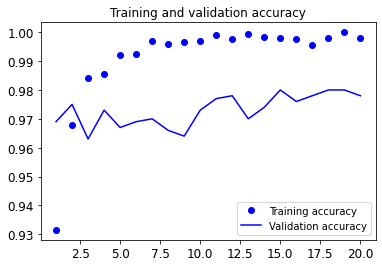

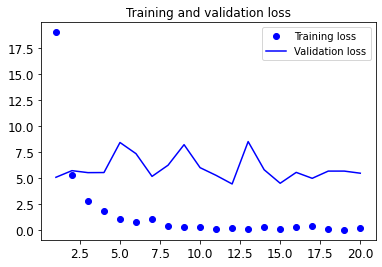

In [25]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We reach a validation accuracy of about 97% — much better than we achieved in Lab 3 with the small model trained from scratch. This is a bit of an unfair
comparison, however, because ImageNet contains many dog and cat instances, which means that our pretrained model already has the exact knowledge required for the task at hand. This won’t always be the case when you use pretrained features.

However, the plots also indicate that we’re overfitting almost from the start—
despite using dropout with a fairly large rate. That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets.

### Feature extraction together with data augmentation

Now let’s review the second technique for doing feature extraction, which is much slower and more expensive, but which allows us to use data augmentation
during training: creating a model that chains the `conv_base` with a new dense
classifier, and training it end to end on the inputs.

In order to do this, **we will first freeze the convolutional base**. Freezing a layer or set of layers means preventing their weights from being updated during training. If we don’t do this, the representations that were previously learned by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned. In Keras, we freeze a layer or model by setting its `trainable` attribute to False.

In [26]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [27]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [28]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Now we can create a new model that chains together which contains a data augmentation stage, our frozen convolutional base and a dense classifier.

In [29]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
# Apply input value scaling.
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

With this setup, only the weights from the two Dense layers that we added will be trained. **That’s a total of four weight tensors: two per layer (the main weight matrix and the bias vector)**. Note that in order for these changes to take effect, you must first compile the model. **If you ever modify weight trainability after compilation, you should then recompile the model, or these changes will be ignored.** 

Let’s train our model. Thanks to data augmentation, it will take much longer for
the model to start overfitting, so we can train for more epochs—let’s do 50.

In [30]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 25s 358ms/step - loss: 19.8788 - accuracy: 0.8965 - val_loss: 4.7018 - val_accuracy: 0.9640
Epoch 2/50
63/63 [==============================] - 23s 355ms/step - loss: 6.0872 - accuracy: 0.9450 - val_loss: 2.8333 - val_accuracy: 0.9740
Epoch 3/50
63/63 [==============================] - 23s 357ms/step - loss: 4.8018 - accuracy: 0.9560 - val_loss: 2.4468 - val_accuracy: 0.9770
Epoch 4/50
63/63 [==============================] - 22s 351ms/step - loss: 4.8202 - accuracy: 0.9575 - val_loss: 3.6325 - val_accuracy: 0.9710
Epoch 5/50
63/63 [==============================] - 22s 350ms/step - loss: 5.6492 - accuracy: 0.9630 - val_loss: 5.3733 - val_accuracy: 0.9560
Epoch 6/50
63/63 [==============================] - 22s 349ms/step - loss: 4.1913 - accuracy: 0.9630 - val_loss: 2.4711 - val_accuracy: 0.9830
Epoch 7/50
63/63 [==============================] - 23s 351ms/step - loss: 3.8926 - accuracy: 0.9680 - val_loss: 3.4613 - val_accuracy: 0.972

Let’s plot the results again. As you can see, we reach a validation accuracy of over 98%. This is a strong improvement over the previous model.

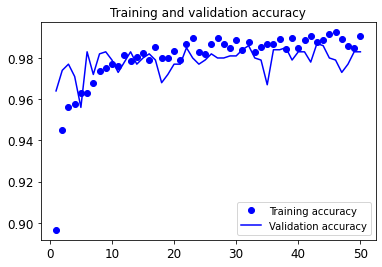

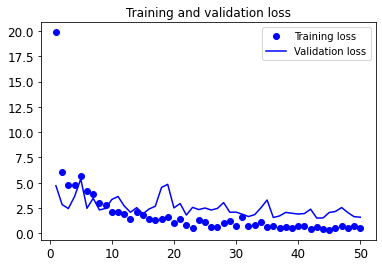

In [31]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [32]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 15s 222ms/step - loss: 2.1967 - accuracy: 0.9785
Test accuracy: 0.979


We get a test accuracy of 97.9%!

### Fine-tuning a pretrained model

We stated earlier that it’s necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. For the
same reason, it’s only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classifier isn’t already trained, the error signal propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed. Thus the steps for fine-tuning a network are as follows:

1. Add our custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part we added.
4. Unfreeze some layers in the base network. (Note that you should not unfreeze “batch normalization” layers, which are not relevant here since there are no such layers in VGG16. Batch normalization and its impact on finetuning is explained in the lecture.)
5. Jointly train both these layers and the part we added.

You already completed the first three steps when doing feature extraction. Let’s proceed with step 4: we’ll unfreeze our conv_base and then freeze individual layers inside it.

In [33]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

We’ll fine-tune the last three convolutional layers, which means all layers up to `block4_pool` should be frozen, and the layers `block5_conv1`, `block5_conv2`, and `block5_conv3` should be trainable.

In [34]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Now we can begin fine-tuning the model. We’ll do this with the `RMSprop` optimizer, using a **very low learning rate**. The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the three layers we’re fine-tuning. Updates that are too large may harm these representations.

In [35]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 27s 387ms/step - loss: 0.5737 - accuracy: 0.9870 - val_loss: 1.4688 - val_accuracy: 0.9830
Epoch 2/30
63/63 [==============================] - 25s 388ms/step - loss: 0.5079 - accuracy: 0.9865 - val_loss: 1.3553 - val_accuracy: 0.9880
Epoch 3/30
63/63 [==============================] - 24s 380ms/step - loss: 0.3673 - accuracy: 0.9920 - val_loss: 1.4342 - val_accuracy: 0.9880
Epoch 4/30
63/63 [==============================] - 24s 380ms/step - loss: 0.1612 - accuracy: 0.9925 - val_loss: 1.4479 - val_accuracy: 0.9860
Epoch 5/30
63/63 [==============================] - 24s 384ms/step - loss: 0.2359 - accuracy: 0.9905 - val_loss: 1.3514 - val_accuracy: 0.9820
Epoch 6/30
63/63 [==============================] - 24s 378ms/step - loss: 0.3810 - accuracy: 0.9905 - val_loss: 1.5342 - val_accuracy: 0.9810
Epoch 7/30
63/63 [==============================] - 24s 379ms/step - loss: 0.2135 - accuracy: 0.9930 - val_loss: 1.3822 - val_accuracy: 0.9830

In [36]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 16s 229ms/step - loss: 1.6907 - accuracy: 0.9755
Test accuracy: 0.975


Here, we get a test accuracy of 97.5%! By leveraging modern deep learning techniques, we managed to reach this result using only a small fraction of the training data that was available for the competition (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

# Using Tensorflow Hub

TensorFlow Hub is a repository of pre-trained TensorFlow models.
https://www.tensorflow.org/hub

## Download the classifier

Select a MobileNetV2 pre-trained model from TensorFlow Hub and wrap it as a Keras layer with hub.KerasLayer. [Any compatible image classifier model from TensorFlow Hub](https://tfhub.dev/s?q=tf2&module-type=image-classification/) will work here, including the examples provided in the drop-down below.

In [66]:
import tensorflow_hub as hub
import PIL.Image as Image

mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
classifier_model = mobilenet_v2

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

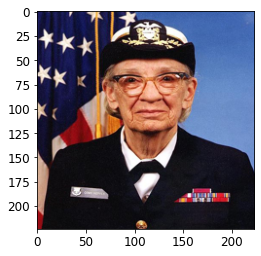

In [67]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
plt.imshow(grace_hopper)

Add a batch dimension (with np.newaxis) and pass the image to the model:

In [68]:
grace_hopper = np.array(grace_hopper)/255.0
result = classifier.predict(grace_hopper[np.newaxis, ...])

The top class ID can be found with `tf.math.argmax`:

In [69]:
predicted_class = tf.math.argmax(result[0], axis=-1)

Take the predicted_class ID and fetch the ImageNet dataset labels to decode the predictions:

24576/10484 [======================================================================] - 0s 0us/step


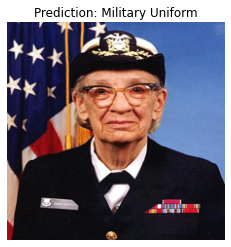

In [70]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Transfer learning

In this example, you will use the TensorFlow flowers dataset:

In [71]:
data_root = tf.keras.utils.get_file(
  'flower_photos',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228827136/228813984 [==============================] - 5s 0us/step


First, load this data into the model using the image data off disk with tf.`keras.utils.image_dataset_from_directory`, which will generate a `tf.data.Dataset`:

In [72]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


The flowers dataset has five classes:

In [73]:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Second, because TensorFlow Hub's convention for image models is to expect float inputs in the `[0, 1]` range, use the `tf.keras.layers.Rescaling` preprocessing layer to achieve this.

In [74]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

Third, finish the input pipeline by using buffered prefetching *with Dataset.prefetch*, so you can yield the data from disk without I/O blocking issues.These are some of the most important `tf.data` methods you should use when loading data. Interested readers can learn more about them, as well as how to cache data to disk and other techniques, in the Better performance with the tf.data API guide.

In [75]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### Run the classifier on a batch of images

In [76]:
result_batch = classifier.predict(train_ds)
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['plastic bag', 'wool', 'rapeseed', ..., 'vase', "jack-o'-lantern",
       'daisy'], dtype='<U30')

Check how these predictions line up with the images:

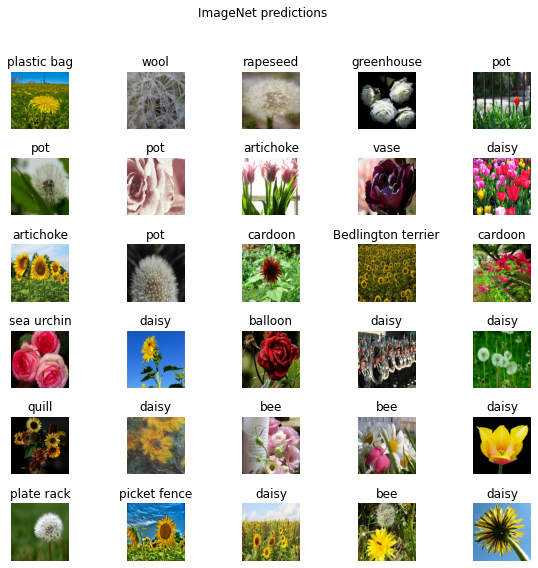

In [77]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except for "daisy").

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

In [79]:
# Note that this time we select feature vector instead of classification
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_model = mobilenet_v2


feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

Create the feature extractor by wrapping the pre-trained model as a Keras layer with hub.KerasLayer. Use the `trainable=False` argument to freeze the variables, so that the training only modifies the new classifier layer:

In [80]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### Attach a classification head

In [81]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_6 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


### Train the model

In [82]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [83]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS)

Epoch 1/10
92/92 [==============================] - 19s 119ms/step - loss: 0.7405 - acc: 0.7255 - val_loss: 0.4417 - val_acc: 0.8638
Epoch 2/10
92/92 [==============================] - 10s 106ms/step - loss: 0.3798 - acc: 0.8702 - val_loss: 0.3620 - val_acc: 0.8842
Epoch 3/10
92/92 [==============================] - 10s 104ms/step - loss: 0.2995 - acc: 0.8992 - val_loss: 0.3292 - val_acc: 0.8965
Epoch 4/10
92/92 [==============================] - 9s 100ms/step - loss: 0.2503 - acc: 0.9257 - val_loss: 0.3110 - val_acc: 0.9060
Epoch 5/10
92/92 [==============================] - 9s 99ms/step - loss: 0.2151 - acc: 0.9397 - val_loss: 0.2994 - val_acc: 0.9074
Epoch 6/10
92/92 [==============================] - 9s 99ms/step - loss: 0.1879 - acc: 0.9496 - val_loss: 0.2915 - val_acc: 0.9087
Epoch 7/10
92/92 [==============================] - 9s 102ms/step - loss: 0.1660 - acc: 0.9567 - val_loss: 0.2860 - val_acc: 0.9046
Epoch 8/10
92/92 [==============================] - 9s 98ms/step - loss: 0.

Obtain the ordered list of class names from the model predictions:

In [85]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

['dandelion' 'dandelion' 'dandelion' 'roses' 'tulips' 'dandelion' 'roses'
 'tulips' 'tulips' 'tulips' 'sunflowers' 'dandelion' 'sunflowers'
 'sunflowers' 'tulips' 'roses' 'sunflowers' 'roses' 'roses' 'dandelion'
 'sunflowers' 'sunflowers' 'roses' 'daisy' 'tulips' 'dandelion'
 'sunflowers' 'sunflowers' 'dandelion' 'dandelion' 'sunflowers' 'roses']


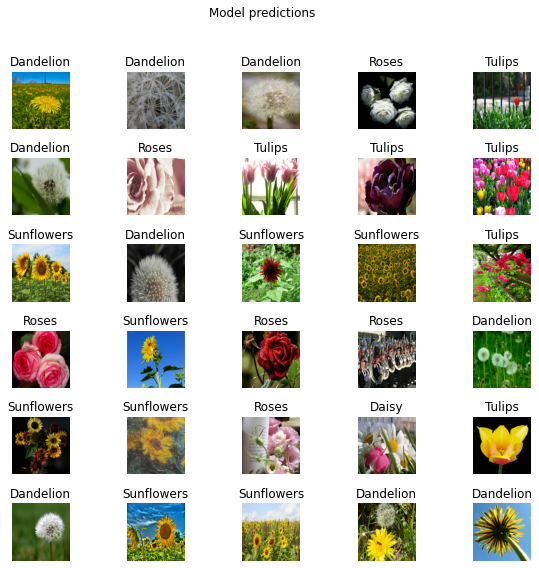

In [86]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

### Export and reload your model

In [87]:
import time

t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1647593754/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1647593754/assets


'/tmp/saved_models/1647593754'

In [88]:
reloaded = tf.keras.models.load_model(export_path)
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)
abs(reloaded_result_batch - result_batch).max()

0.0

# Self-supervised learning

Semi-supervised learning is a machine learning paradigm that deals with partially labeled datasets. When applying deep learning in the real world, one usually has to gather a large dataset to make it work well. However, while the cost of labeling scales linearly with the dataset size (labeling each example takes a constant time), model performance only scales sublinearly with it. This means that labeling more and more samples becomes less and less cost-efficient, while gathering unlabeled data is generally cheap, as it is usually readily available in large quantities.

Semi-supervised learning offers to solve this problem by only requiring a partially labeled dataset, and by being label-efficient by utilizing the unlabeled examples for learning as well. In this example, we will pretrain an encoder with contrastive learning on the STL-10 semi-supervised dataset using no labels at all, and then fine-tune it using only its labeled subset.

https://ai.stanford.edu/~acoates/stl10/

The key insight is that you can train a self-supervised model to learn data representations by contrasting multiple augmented views of the same example. These **learned representations capture data invariants**, e.g., object translation, color jitter, noise, etc. One such contrastive approach is `SimCLR`, which essentially identifies the core components needed to optimize this objective, and can achieve high performance by scaling this simple approach.Another approach is `SimSiam`.

Training a simple linear classifier on top of the frozen representations is easier and requires fewer labels because the pre-trained model already produces meaningful and generally useful features. Overall, self-supervised pre-training learns representations which are more generic and robust than other approaches to augmented training and pre-training.

In [37]:
# Dataset hyperparameters for STL dataset
unlabeled_dataset_size = 100000
labeled_dataset_size = 5000
image_size = 96
image_channels = 3

# Algorithm hyperparameters
num_epochs = 20
batch_size = 525  # Corresponds to 200 steps per epoch, note that SimCLR requires a large batch size
width = 128
temperature = 0.1
# Stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

## Loading the dataset

During training we will simultaneously load a large batch of unlabeled images along with a smaller batch of labeled images. We will use tfds to download the data.

In [39]:
import tensorflow_datasets as tfds

def prepare_dataset():
    # Labeled and unlabeled samples are loaded synchronously
    # with batch sizes selected accordingly
    steps_per_epoch = (unlabeled_dataset_size + labeled_dataset_size) // batch_size
    unlabeled_batch_size = unlabeled_dataset_size // steps_per_epoch
    labeled_batch_size = labeled_dataset_size // steps_per_epoch
    print(
        f"batch size is {unlabeled_batch_size} (unlabeled) + {labeled_batch_size} (labeled)"
    )

    unlabeled_train_dataset = (
        tfds.load("stl10", split="unlabelled", as_supervised=True, shuffle_files=True)
        .shuffle(buffer_size=10 * unlabeled_batch_size)
        .batch(unlabeled_batch_size)
    )
    labeled_train_dataset = (
        tfds.load("stl10", split="train", as_supervised=True, shuffle_files=True)
        .shuffle(buffer_size=10 * labeled_batch_size)
        .batch(labeled_batch_size)
    )
    test_dataset = (
        tfds.load("stl10", split="test", as_supervised=True)
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    # Labeled and unlabeled datasets are zipped together
    train_dataset = tf.data.Dataset.zip(
        (unlabeled_train_dataset, labeled_train_dataset)
    ).prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, labeled_train_dataset, test_dataset


# Load STL10 dataset
train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()

batch size is 500 (unlabeled) + 25 (labeled)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incompleteHVJWT4/stl10-train.tfrecord


  0%|          | 0/5000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incompleteHVJWT4/stl10-test.tfrecord


  0%|          | 0/8000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incompleteHVJWT4/stl10-unlabelled.tfrecord


  0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset stl10 downloaded and prepared to /root/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.


## Image augmentations

The two most important image augmentations for contrastive learning are the following:

* Cropping: forces the model to encode different parts of the same image similarly, we implement it with the `RandomTranslation` and `RandomZoom` layers
* Color jitter: prevents a trivial color histogram-based solution to the task by distorting color histograms. A principled way to implement that is by affine transformations in color space. 

In this example we use random horizontal flips as well. Stronger augmentations are applied for contrastive learning, along with weaker ones for supervised classification to avoid overfitting on the few labeled examples.

We implement random color jitter as a custom preprocessing layer. Using preprocessing layers for data augmentation has the following two advantages:

* The data augmentation will run on GPU in batches, so the training will not be bottlenecked by the data pipeline in environments with constrained CPU resources (such as a Colab Notebook, or a personal machine)
* Deployment is easier as the data preprocessing pipeline is encapsulated in the model, and does not have to be reimplemented when deploying it

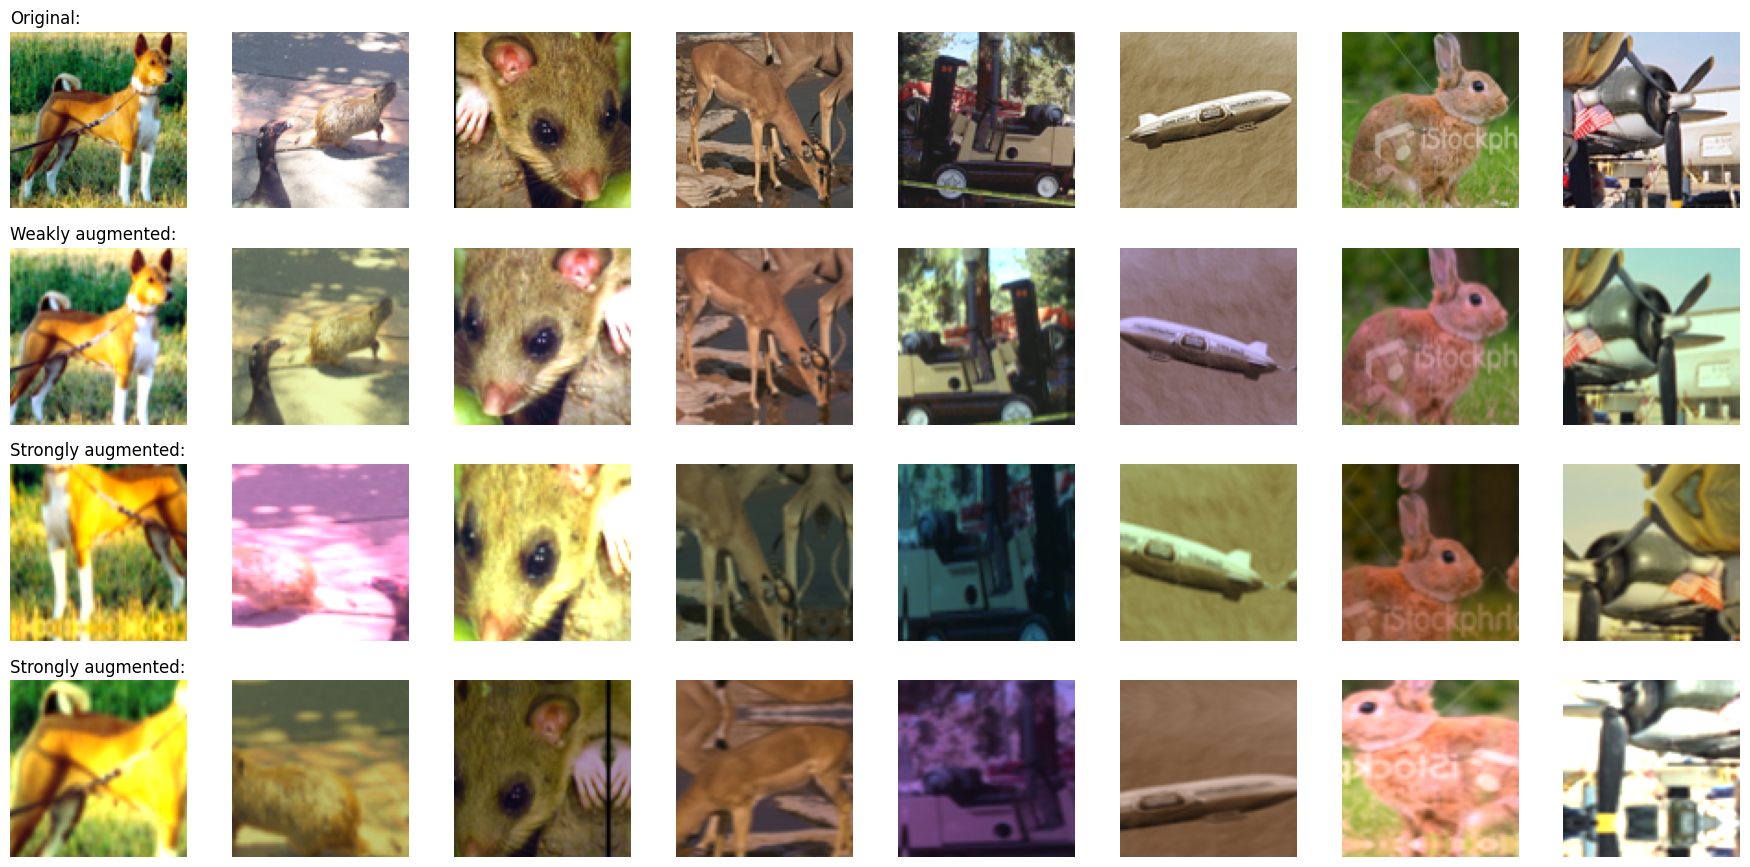

In [43]:
import math

# Distorts the color distibutions of images
class RandomColorAffine(layers.Layer):
    def __init__(self, brightness=0, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.brightness = brightness
        self.jitter = jitter

    def get_config(self):
        config = super().get_config()
        config.update({"brightness": self.brightness, "jitter": self.jitter})
        return config

    def call(self, images, training=True):
        if training:
            batch_size = tf.shape(images)[0]

            # Same for all colors
            brightness_scales = 1 + tf.random.uniform(
                (batch_size, 1, 1, 1), minval=-self.brightness, maxval=self.brightness
            )
            # Different for all colors
            jitter_matrices = tf.random.uniform(
                (batch_size, 1, 3, 3), minval=-self.jitter, maxval=self.jitter
            )

            color_transforms = (
                tf.eye(3, batch_shape=[batch_size, 1]) * brightness_scales
                + jitter_matrices
            )
            images = tf.clip_by_value(tf.matmul(images, color_transforms), 0, 1)
        return images


# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - math.sqrt(min_area)
    return keras.Sequential(
        [
            keras.Input(shape=(image_size, image_size, image_channels)),
            layers.Rescaling(1 / 255),
            layers.RandomFlip("horizontal"),
            layers.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
            layers.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)),
            RandomColorAffine(brightness, jitter),
        ]
    )



def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(iter(train_dataset))[0][0][:num_images]
    # Apply augmentations
    augmented_images = zip(
        images,
        get_augmenter(**classification_augmentation)(images, training=True),
        get_augmenter(**contrastive_augmentation)(images, training=True),
        get_augmenter(**contrastive_augmentation)(images, training=True),
    )
    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
        "Strongly augmented:",
    ]
    plt.figure(figsize=(num_images * 2.2, 4 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


visualize_augmentations(num_images=8)

We first define the encoder architecture as below

In [44]:
# Define the encoder architecture
def get_encoder():
    return keras.Sequential(
        [
            keras.Input(shape=(image_size, image_size, image_channels)),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )

## Supervised baseline model

In [45]:
# Baseline supervised training with random initialization
baseline_model = keras.Sequential(
    [
        keras.Input(shape=(image_size, image_size, image_channels)),
        get_augmenter(**classification_augmentation),
        get_encoder(),
        layers.Dense(10),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)
# Use labeled dataset here
baseline_history = baseline_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Epoch 1/20
200/200 [==============================] - 13s 53ms/step - loss: 2.0387 - acc: 0.2376 - val_loss: 1.7274 - val_acc: 0.3598
Epoch 2/20
200/200 [==============================] - 12s 56ms/step - loss: 1.7402 - acc: 0.3490 - val_loss: 1.5816 - val_acc: 0.4134
Epoch 3/20
200/200 [==============================] - 9s 46ms/step - loss: 1.6190 - acc: 0.3972 - val_loss: 1.5420 - val_acc: 0.4295
Epoch 4/20
200/200 [==============================] - 9s 46ms/step - loss: 1.5247 - acc: 0.4378 - val_loss: 1.4040 - val_acc: 0.4823
Epoch 5/20
200/200 [==============================] - 9s 46ms/step - loss: 1.4637 - acc: 0.4582 - val_loss: 1.3758 - val_acc: 0.4945
Epoch 6/20
200/200 [==============================] - 9s 46ms/step - loss: 1.4182 - acc: 0.4668 - val_loss: 1.4303 - val_acc: 0.4760
Epoch 7/20
200/200 [==============================] - 9s 46ms/step - loss: 1.3594 - acc: 0.4932 - val_loss: 1.4253 - val_acc: 0.4874
Epoch 8/20
200/200 [==============================] - 9s 46ms/step 

## Self-supervised model for contrastive pretraining

We pretrain an encoder on unlabeled images with a contrastive loss. A nonlinear projection head is attached to the top of the encoder, as it improves the quality of representations of the encoder.

We use the InfoNCE/NT-Xent/N-pairs loss, which can be interpreted in the following way:

1. We treat each image in the batch as if it had its own class.
2. Then, we have two examples (a pair of augmented views) for each "class".
3. Each view's representation is compared to every possible pair's one (for both augmented versions).
4. We use the temperature-scaled cosine similarity of compared representations as logits.
5. Finally, we use categorical cross-entropy as the "classification" loss

The following two metrics are used for monitoring the pretraining performance:

* `Contrastive accuracy`: Self-supervised metric, the ratio of cases in which **the representation of an image is more similar to its differently augmented version's one, than to the representation of any other image in the current batch.** Self-supervised metrics can be used for hyperparameter tuning even in the case when there are no labeled examples.

* `Linear probing accuracy`: Linear probing is a popular metric to evaluate self-supervised classifiers. It is computed as the accuracy of a logistic regression classifier trained on top of the encoder's features. In our case, this is done by training a single dense layer on top of the frozen encoder. **Note that contrary to traditional approach where the classifier is trained after the pretraining phase, in this example we train it during pretraining.** This might slightly decrease its accuracy, but that way we can monitor its value during training, which helps with experimentation and debugging.

Another widely used supervised metric is the KNN accuracy, which is the accuracy of a KNN classifier trained on top of the encoder's features, which is not implemented here.

In [46]:
# Define the contrastive model with subclassing API
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.classification_augmenter = get_augmenter(**classification_augmentation)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(10)], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        (unlabeled_images, _), (labeled_images, labels) = data

        # Both labeled and unlabeled images are used, without labels
        images = tf.concat((unlabeled_images, labeled_images), axis=0)
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images, training=True)
        augmented_images_2 = self.contrastive_augmenter(images, training=True)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=True
        )
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(preprocessed_images, training=False)
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history = pretraining_model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 47, 47, 128)       3584      
                                                                 
 conv2d_5 (Conv2D)           (None, 23, 23, 128)       147584    
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 11, 128)       147584    
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 5, 128)         147584    
                                                                 
 flatten_3 (Flatten)         (None, 3200)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               409728    
                                                                 
Total params: 856,064
Trainable params: 856,064
Non-trainab

## Supervised finetuning of the pretrained encoder

We then finetune the encoder on the labeled examples, by attaching a single randomly initalized fully connected classification layer on its top.

In [47]:
# Supervised finetuning of the pretrained encoder
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=(image_size, image_size, image_channels)),
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
        layers.Dense(10),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

finetuning_history = finetuning_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_acc"]) * 100
    )
)

Epoch 1/20
200/200 [==============================] - 11s 46ms/step - loss: 1.7567 - acc: 0.3358 - val_loss: 1.4428 - val_acc: 0.4473
Epoch 2/20
200/200 [==============================] - 9s 44ms/step - loss: 1.4190 - acc: 0.4706 - val_loss: 1.2621 - val_acc: 0.5396
Epoch 3/20
200/200 [==============================] - 9s 45ms/step - loss: 1.2457 - acc: 0.5442 - val_loss: 1.1434 - val_acc: 0.5891
Epoch 4/20
200/200 [==============================] - 9s 45ms/step - loss: 1.1572 - acc: 0.5800 - val_loss: 1.2348 - val_acc: 0.5604
Epoch 5/20
200/200 [==============================] - 9s 44ms/step - loss: 1.0637 - acc: 0.6214 - val_loss: 1.1461 - val_acc: 0.6079
Epoch 6/20
200/200 [==============================] - 9s 45ms/step - loss: 1.0107 - acc: 0.6358 - val_loss: 1.1768 - val_acc: 0.5990
Epoch 7/20
200/200 [==============================] - 11s 52ms/step - loss: 0.9671 - acc: 0.6460 - val_loss: 1.0224 - val_acc: 0.6381
Epoch 8/20
200/200 [==============================] - 9s 44ms/step 

## Comparison against the baseline

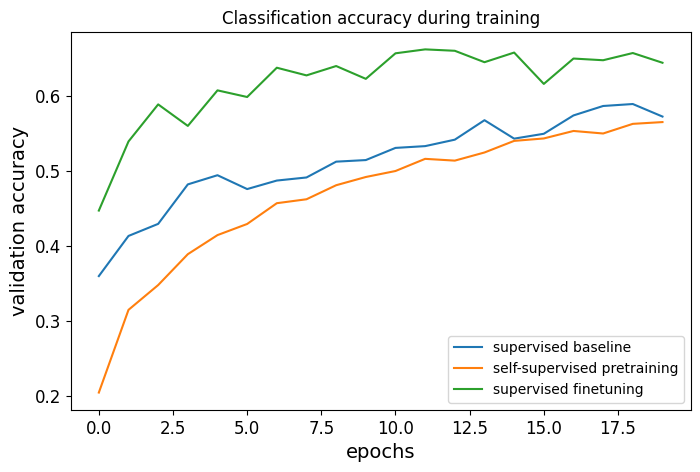

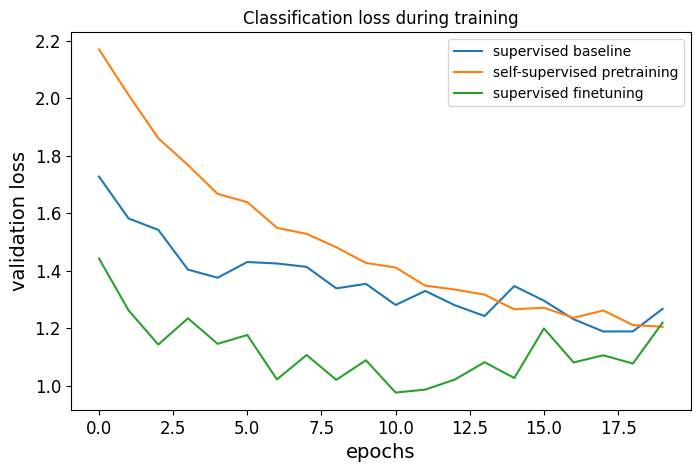

In [48]:
# The classification accuracies of the baseline and the pretraining + finetuning process:
def plot_training_curves(pretraining_history, finetuning_history, baseline_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history.history[f"val_{metric_key}"], label="supervised baseline"
        )
        plt.plot(
            pretraining_history.history[f"val_p_{metric_key}"],
            label="self-supervised pretraining",
        )
        plt.plot(
            finetuning_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(pretraining_history, finetuning_history, baseline_history)

By comparing the training curves, we can see that when using contrastive pretraining, a higher validation accuracy can be reached, paired with a lower validation loss, which means that the pretrained network was able to generalize better when seeing only a small amount of labeled examples.

For a different task or model architecture these would need tuning, so here are some notes on the most important ones:

* Batch size: since the objective can be interpreted as a classification over a batch of images (loosely speaking), the batch size is actually a more important hyperparameter than usual. The higher, the better.

* Temperature: the temperature defines the "softness" of the softmax distribution that is used in the cross-entropy loss, and is an important hyperparameter. Lower values generally lead to a higher contrastive accuracy. A recent trick (in ALIGN) is to learn the temperature's value as well (which can be done by defining it as a tf.Variable, and applying gradients on it). Even though this provides a good baseline value, in my experiments the learned temperature was somewhat lower than optimal, as it is optimized with respect to the contrastive loss, which is not a perfect proxy for representation quality.

* Image augmentation strength: during pretraining stronger augmentations increase the difficulty of the task, however after a point too strong augmentations will degrade performance. During finetuning stronger augmentations reduce overfitting while in my experience too strong augmentations decrease the performance gains from pretraining. The whole data augmentation pipeline can be seen as an important hyperparameter of the algorithm, implementations of other custom image augmentation layers in Keras can be found in this repository.

* Learning rate schedule: a constant schedule is used here, but it is quite common in the literature to use a cosine decay schedule, which can further improve performance. Optimizer: Adam is used in this example, as it provides good performance with default parameters. SGD with momentum requires more tuning, however it could slightly increase performance.

For more information refer to https://github.com/tensorflow/similarity/blob/master/examples/unsupervised_hello_world.ipynb

# Domain adverserial training

Here we will try to use domain adversarial learning to transfer the knowledge from MNIST to a modified version of MNIST call MNIST-M (MNIST with random colour patches). We will train on MNIST and test on MNIST-M and make the features of the classifier invariant to the domain to boost performance.

We firt import MNIST and convert to RGB by replicating across 3 dimensions:

In [45]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.stack((x_train,)*3, axis=-1)
x_test = np.stack((x_test,)*3, axis=-1)

### Generate MNIST_M

In [2]:
!curl -L -O http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   162  100   162    0     0    570      0 --:--:-- --:--:-- --:--:--   570
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 67.4M  100 67.4M    0     0  28.7M      0  0:00:02  0:00:02 --:--:-- 55.4M


In [24]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras

import tarfile
import os
import pickle as pkl
import numpy as np
import skimage
import skimage.io
import skimage.transform

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [25]:
BST_PATH = 'BSR_bsds500.tgz'

rand = np.random.RandomState(42)

f = tarfile.open(BST_PATH)
train_files = []
for name in f.getnames():
    if name.startswith('BSR/BSDS500/data/images/train/'):
        train_files.append(name)

print('Loading BSR training images')
background_data = []
for name in train_files:
    try:
        fp = f.extractfile(name)
        bg_img = skimage.io.imread(fp)
        background_data.append(bg_img)
    except:
        continue

Loading BSR training images


In [26]:
def compose_image(digit, background):
    """Difference-blend a digit and a random patch from a background image."""
    w, h, _ = background.shape
    dw, dh, _ = digit.shape
    x = np.random.randint(0, w - dw)
    y = np.random.randint(0, h - dh)
    
    bg = background[x:x+dw, y:y+dh]
    return np.abs(bg - digit).astype(np.uint8)


def mnist_to_img(x):
    """Binarize MNIST digit and convert to RGB."""
    x = (x > 0).astype(np.float32)
    d = x.reshape([28, 28, 1]) * 255
    return np.concatenate([d, d, d], 2)


def create_mnistm(X):
    """
    Give an array of MNIST digits, blend random background patches to
    build the MNIST-M dataset as described in
    http://jmlr.org/papers/volume17/15-239/15-239.pdf
    """
    X_ = np.zeros([X.shape[0], 28, 28, 3], np.uint8)
    for i in range(X.shape[0]):

        if i % 1000 == 0:
            print('Processing example', i)

        bg_img = rand.choice(background_data)

        d = mnist_to_img(X[i])
        d = compose_image(d, bg_img)
        X_[i] = d

    return X_


print('Building train set...')
train = create_mnistm(x_train)
print('Building test set...')
test = create_mnistm(x_test)

Building train set...
Processing example 0
Processing example 1000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Processing example 2000
Processing example 3000
Processing example 4000
Processing example 5000
Processing example 6000
Processing example 7000
Processing example 8000
Processing example 9000
Processing example 10000
Processing example 11000
Processing example 12000
Processing example 13000
Processing example 14000
Processing example 15000
Processing example 16000
Processing example 17000
Processing example 18000
Processing example 19000
Processing example 20000
Processing example 21000
Processing example 22000
Processing example 23000
Processing example 24000
Processing example 25000
Processing example 26000
Processing example 27000
Processing example 28000
Processing example 29000
Processing example 30000
Processing example 31000
Processing example 32000
Processing example 33000
Processing example 34000
Processing example 35000
Processing example 36000
Processing example 37000
Processing example 38000
Processing example 39000
Processing example 40000
Processing example 41000
Processi

In [34]:
# Save dataset as pickle
with open('mnistm_data.pkl', 'wb') as f:
    pkl.dump({ 'train': train, 'test': test}, f, pkl.HIGHEST_PROTOCOL)

### Load MNIST_m

We generate MNIST-M as described in https://github.com/pumpikano/tf-dann/blob/master/create_mnistm.py. The MNIST-M dataset consists of MNIST digits blended with random color patches from the BSDS500 dataset.

https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html#bsds500

We have created a pickle file that you can download from the course website 

In [35]:
with open("mnistm_data.pkl", 'rb') as f:
  mnist_m = pkl.load(f)

In [36]:
mnist_m_train = mnist_m['train']
mnist_m_test = mnist_m['test']

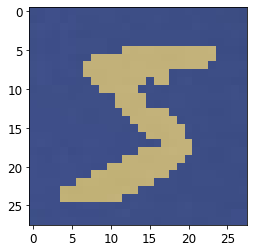

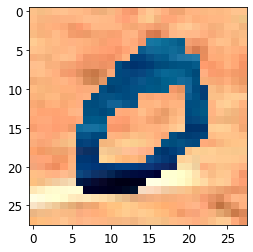

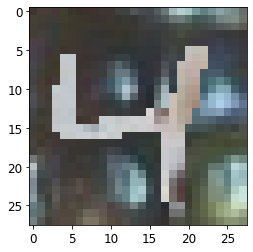

In [41]:
for i in range(3):
  plt.imshow(mnist_m_train[i])
  plt.show()

## Baseline on MNIST-M

We will firt train on MNIST dataset and test it on MNIST-M dataset. We first combine MNIST and MNIST-M images, to get the channel stats for normalisation.

In [46]:
all_train_domain_images = np.vstack((x_train, mnist_m_train))
channel_mean = all_train_domain_images.mean((0,1,2))

In [48]:
class BaselineModel(keras.Model):
  def __init__(self):
    super(BaselineModel, self).__init__()
    
    self.normalise = lambda x: (tf.cast(x, tf.float64) - channel_mean) / 255.0
    self.conv1 = keras.layers.Conv2D(64, 5, activation='relu')
    self.conv2 = keras.layers.Conv2D(128, 5, activation='relu')
    self.maxpool = keras.layers.MaxPool2D(2)
    self.flatten = keras.layers.Flatten()
    
    self.d1 = keras.layers.Dense(128, activation='relu')
    self.d2 = keras.layers.Dense(10, activation='softmax')
    

  def call(self, x):
    x = self.normalise(x)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.d1(x)

    return self.d2(x)

model = BaselineModel()

In [49]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
1875/1875 [==============================] - 41s 15ms/step - loss: 0.0918 - accuracy: 0.9724 - val_loss: 0.0502 - val_accuracy: 0.9820
Epoch 2/20
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0358 - accuracy: 0.9888 - val_loss: 0.0521 - val_accuracy: 0.9842
Epoch 3/20
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0239 - accuracy: 0.9927 - val_loss: 0.0363 - val_accuracy: 0.9894
Epoch 4/20
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0192 - accuracy: 0.9941 - val_loss: 0.0443 - val_accuracy: 0.9903
Epoch 5/20
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0141 - accuracy: 0.9955 - val_loss: 0.0445 - val_accuracy: 0.9893
Epoch 6/20
1875/1875 [==============================] - 33s 18ms/step - loss: 0.0127 - accuracy: 0.9965 - val_loss: 0.0539 - val_accuracy: 0.9885
Epoch 7/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0119 - accuracy: 0.9966 - val_loss: 0.0677 -

In [50]:
score = model.evaluate(mnist_m_test,y_test)

313/313 [==============================] - 2s 6ms/step - loss: 3.3995 - accuracy: 0.5565


## Domain confusion

Next, we build separate components so that distinct sets of gradients are easily accessed:

In [51]:
class FeatureGenerator(keras.Model):
  def __init__(self):
    super(FeatureGenerator, self).__init__() 
    self.normalise = lambda x: (tf.cast(x, tf.float64) - channel_mean) / 255.0
    self.conv1 = keras.layers.Conv2D(64, 5, activation='relu')
    self.conv2 = keras.layers.Conv2D(128, 5, activation='relu')
    self.maxpool = keras.layers.MaxPool2D(2)
    self.flatten = keras.layers.Flatten()
    
  def call(self, x):
    x = self.normalise(x)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.maxpool(x)

    return self.flatten(x)

feature_generator = FeatureGenerator()

In [52]:
class LabelPredictor(keras.Model):
  def __init__(self):
    super(LabelPredictor, self).__init__() 
    self.d1 = keras.layers.Dense(128, activation='relu')
    self.d2 = keras.layers.Dense(10, activation='softmax')
    

  def call(self, feats):  
    feats = self.d1(feats)

    return self.d2(feats)

label_predictor = LabelPredictor()

In [54]:
class DomainPredictor(keras.Model):
  def __init__(self):
    super(DomainPredictor, self).__init__()   
    self.d3 = keras.layers.Dense(64, activation='relu')
    self.d4 = keras.layers.Dense(2, activation='softmax')

  def call(self, feats):
    feats = self.d3(feats)
    
    return self.d4(feats)

domain_predictor = DomainPredictor()

Make second training dataset of MNIST and MNIST-M images and their respective domains

In [55]:
x_train_domain_labels = np.ones([len(x_train)])
mnist_m_train_domain_labels = np.zeros([len(mnist_m_train)])
all_train_domain_labels = np.hstack((x_train_domain_labels, mnist_m_train_domain_labels))


train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(60000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)
domain_train_ds = tf.data.Dataset.from_tensor_slices(
    (all_train_domain_images, tf.cast(all_train_domain_labels, tf.int8))).shuffle(60000).batch(32)
mnist_m_train_ds = tf.data.Dataset.from_tensor_slices((mnist_m_train,y_train)).batch(32)
mnist_m_test_ds = tf.data.Dataset.from_tensor_slices((mnist_m_test,y_test)).batch(32)

Separate optimizers to allow different learning rates

In [56]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
f_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [57]:
# Discriminative losses
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

m_test_loss = tf.keras.metrics.Mean(name='m_test_loss')
m_test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='m_test_accuracy')

In [58]:
# Confusion loss
conf_train_loss = tf.keras.metrics.Mean(name='c_train_loss')
conf_train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='c_train_accuracy')

There are three sets of parameters to update, one for each component of the model. Label and domain classifiers are updated in the usual way. Parameters of the feature generator are updated using the standard gradient backpropagated from the label classifier, summed with the reverse of the gradient from the domain classifier; the feature generator learns to confound the domain classifier, resulting in domain invariant features which should be useful for general performance.

But here instead of using Gradient Reversal Layer as describe in https://arxiv.org/abs/1409.7495. We use asynchronous updating that is similar to GAN which seems to work a bit better, with better accuracy and stability. We also use `tf.function` decorector as described in https://www.tensorflow.org/api_docs/python/tf/function.

In [59]:
@tf.function
def train_step(images, labels, images2, domains, alpha):
    
  """
  i. images = batch of source images
  ii. labels = corresponding labels
  iii. images2 = batch of source and target images
  iv. domains = corresponding domain labels
  v. alpha = weight attributed to the domain loss
  """
    
  ## Update the generator and the classifier
  with tf.GradientTape(persistent=True) as tape:
    features = feature_generator(images)
    l_predictions = label_predictor(features)
    features = feature_generator(images2)
    d_predictions = domain_predictor(features)
    label_loss = loss_object(labels, l_predictions)
    domain_loss = loss_object(domains, d_predictions)
    
  f_gradients_on_label_loss = tape.gradient(label_loss, feature_generator.trainable_variables)
  f_gradients_on_domain_loss = tape.gradient(domain_loss, feature_generator.trainable_variables)    
  f_gradients = [f_gradients_on_label_loss[i] - alpha*f_gradients_on_domain_loss[
      i] for i in range(len(f_gradients_on_domain_loss))]

    
  l_gradients = tape.gradient(label_loss, label_predictor.trainable_variables)

  f_optimizer.apply_gradients(zip(f_gradients+l_gradients, 
                                  feature_generator.trainable_variables+label_predictor.trainable_variables)) 
    
    
  ## Update the discriminator: Comment this bit to complete all updates in one step. Asynchronous updating 
  ## seems to work a bit better, with better accuracy and stability, but may take longer to train    
  with tf.GradientTape() as tape:
    features = feature_generator(images2)
    d_predictions = domain_predictor(features)
    domain_loss = loss_object(domains, d_predictions)
  #####
   
  d_gradients = tape.gradient(domain_loss, domain_predictor.trainable_variables)  
  d_gradients = [alpha*i for i in d_gradients]
  d_optimizer.apply_gradients(zip(d_gradients, domain_predictor.trainable_variables))
  
    
    
  train_loss(label_loss)
  train_accuracy(labels, l_predictions)
  conf_train_loss(domain_loss)
  conf_train_accuracy(domains, d_predictions)

In [60]:
@tf.function
def test_step(mnist_images, labels, mnist_m_images, labels2):
  features = feature_generator(mnist_images)
  predictions = label_predictor(features)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

  features = feature_generator(mnist_m_images)
  predictions = label_predictor(features)
  t_loss = loss_object(labels2, predictions)
    
  m_test_loss(t_loss)
  m_test_accuracy(labels2, predictions)

In [61]:
def reset_metrics():
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    m_test_loss.reset_states()
    m_test_accuracy.reset_states()

In [62]:
EPOCHS = 20

alpha = 1
for epoch in range(EPOCHS):
  reset_metrics()
  
  for domain_data, label_data in zip(domain_train_ds, train_ds):
    
    try:
      train_step(label_data[0], label_data[1], domain_data[0], domain_data[1], alpha=alpha)
     
    #End of the smaller dataset
    except ValueError: 
      pass
    
  for test_data, m_test_data in zip(test_ds,mnist_m_test_ds):
    test_step(test_data[0], test_data[1], m_test_data[0], m_test_data[1])
  
  template = 'Epoch {}, Train Accuracy: {}, Domain Accuracy: {}, Source Test Accuracy: {}, Target Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_accuracy.result()*100,
                         conf_train_accuracy.result()*100,
                         test_accuracy.result()*100,
                         m_test_accuracy.result()*100,))

Epoch 1, Train Accuracy: 94.31333923339844, Domain Accuracy: 70.7300033569336, Source Test Accuracy: 96.8499984741211, Target Test Accuracy: 54.63999938964844
Epoch 2, Train Accuracy: 96.44166564941406, Domain Accuracy: 68.9183349609375, Source Test Accuracy: 98.04999542236328, Target Test Accuracy: 63.70000076293945
Epoch 3, Train Accuracy: 85.31666564941406, Domain Accuracy: 73.26667022705078, Source Test Accuracy: 66.4699935913086, Target Test Accuracy: 19.100000381469727
Epoch 4, Train Accuracy: 80.625, Domain Accuracy: 79.19708251953125, Source Test Accuracy: 90.56999969482422, Target Test Accuracy: 27.079999923706055
Epoch 5, Train Accuracy: 91.88166809082031, Domain Accuracy: 81.31999969482422, Source Test Accuracy: 93.91000366210938, Target Test Accuracy: 49.349998474121094
Epoch 6, Train Accuracy: 94.69000244140625, Domain Accuracy: 80.27027893066406, Source Test Accuracy: 96.17000579833984, Target Test Accuracy: 62.19999694824219
Epoch 7, Train Accuracy: 96.04833221435547, Do